### Урок3. Связь бизнес-показателей и DS-метрик

В рамках конкурса вам нужно предсказать наличие сердечно-сосудистых заболеваний по результатам классического врачебного осмотра. Датасет сформирован из 100.000 реальных клинических анализов, и в нём используются признаки, которые можно разбить на 3 группы:

 

Объективные признаки:

 - Возраст
 - Рост
 - Вес
 - Пол
 

Результаты измерения:

 - Артериальное давление верхнее и нижнее
 - Холестерин
 - Глюкоза
 

Субъективные признаки:

 - Курение
 - Употребление Алкоголя
 - Физическая активность
 

Возраст дан в днях. Значения показателей холестерина и глюкозы представлены одним из трех классов: норма, выше нормы, значительно выше нормы. Значения субъективных признаков — бинарны.

Все показатели даны на момент осмотра.

Таргет - наличие сердечно-сосудистых заболеваний (ССЗ)

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
link = '/content/drive/MyDrive/train_case2.csv'

In [ ]:
df = pd.read_csv(link, ';')
df.head(3)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


Разделим наши данные на тренировочную и тестовую выборки

In [ ]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1), 
                                                    df['cardio'], random_state=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


К полям:
- gender, cholesterol применим OHE-кодирование
- age, height, weight, ap_hi, ap_lo - standardScaler
- gluc, smoke, alco, active - оставим пока как есть

In [ ]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]


from sklearn.preprocessing import StandardScaler


continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

Теперь объединим все наши трансформеры с помощью FeatureUnion

In [ ]:
from sklearn.pipeline import FeatureUnion

feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[-1.73391771,  0.6873301 ,  0.74843904, ...,  1.        ,
         0.        ,  1.        ],
       [-1.67343538,  0.07758923, -0.29640123, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.13738132,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.17775864,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  1.        ],
       [-0.47190715, -1.38578883,  0.74843904, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.38174619,  0.56538192, -0.08743318, ...,  0.        ,
         0.        ,  1.        ]])

Добавим классификатор и запустим кросс-валидацию

In [ ]:
classifier_LR = Pipeline([
    ('features',feats),
    ('classifier_LR', LogisticRegression(random_state = 42)),
])


#запустим кросс-валидацию
cv_scores_LR = cross_val_score(classifier_LR, X_train, y_train, cv=16, scoring='roc_auc')
cv_score_LR = np.mean(cv_scores_LR)
cv_score_std_LR = np.std(cv_scores_LR)
print('CV score for LogReg is {}+-{}'.format(cv_score_LR, cv_score_std_LR))

#обучим пайплайн на всем тренировочном датасете
classifier_LR.fit(X_train, y_train)
y_score_LR = classifier_LR.predict_proba(X_test)[:, 1]

CV score for LogReg is 0.7867401104915408+-0.00852135511666111


In [ ]:
from sklearn.ensemble import RandomForestClassifier

classifier_RF = Pipeline([
    ('features',feats),
    ('classifier_RF', RandomForestClassifier(random_state = 42)),
])


#запустим кросс-валидацию
cv_scores_RF = cross_val_score(classifier_RF, X_train, y_train, cv=16, scoring='roc_auc')
cv_score_RF = np.mean(cv_scores_RF)
cv_score_std_RF = np.std(cv_scores_RF)
print('CV score for Random Forest is {}+-{}'.format(cv_score_RF, cv_score_std_RF))

#обучим пайплайн на всем тренировочном датасете
classifier_RF.fit(X_train, y_train)
y_score_RF = classifier_RF.predict_proba(X_test)[:, 1]

CV score for Random Forest is 0.7734501681056019+-0.007171140345435727


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

classifier_GB = Pipeline([
    ('features',feats),
    ('classifier_RF', GradientBoostingClassifier(random_state = 42)),
])


#запустим кросс-валидацию
cv_scores_GB = cross_val_score(classifier_GB, X_train, y_train, cv=16, scoring='roc_auc')
cv_score_GB = np.mean(cv_scores_GB)
cv_score_std_GB = np.std(cv_scores_GB)
print('CV score for GradBoost is {}+-{}'.format(cv_score_GB, cv_score_std_GB))

#обучим пайплайн на всем тренировочном датасете
classifier_GB.fit(X_train, y_train)
y_score_GB = classifier_GB.predict_proba(X_test)[:, 1]

CV score for GradBoost is 0.8025125910838183+-0.00707472977074522


Посчитаем precision/recall/f_score

In [ ]:
def pr_rec(y_test,y_score, b=1):

  precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
  fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
  # locate the index of the largest f score
  ix = np.argmax(fscore)
  return thresholds [ix], fscore [ix], precision [ix], recall [ix]
thresholds_LR, fscore_LR, pres_LR, recall_LR = pr_rec(y_test, y_score_LR) 
print(thresholds_LR, fscore_LR, pres_LR, recall_LR)

0.3869370891147378 0.7303229695112764 0.6474307596402173 0.8375576036866359


In [ ]:
thresholds_RF, fscore_RF, pres_RF, recall_RF = pr_rec(y_test, y_score_RF) 
print(thresholds_RF, fscore_RF, pres_RF, recall_RF)

0.35 0.7188626554963188 0.6426690876078075 0.8155529953917051


In [ ]:
thresholds_GB, fscore_GB, pres_GB, recall_GB = pr_rec(y_test, y_score_GB) 
print(thresholds_GB, fscore_GB, pres_GB, recall_GB)

0.39494659702686624 0.7402477952713303 0.6978475976741814 0.7881336405529954


Нарисуем roc auc кривую (кстати, наверное неплохо бы ее вынести в отдельную функцию)

In [ ]:
def roc_curve_plot(y_test, y_score):
  
  sns.set(font_scale=1.5)
  sns.set_color_codes("muted")

  plt.figure(figsize=(10, 8))
  fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
  lw = 2
  plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
  plt.plot([0, 1], [0, 1])
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC curve')
  plt.savefig("ROC.png")
  plt.show()

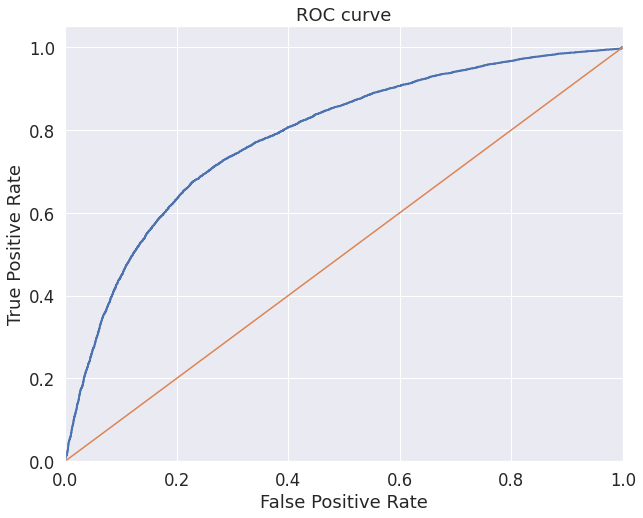

In [ ]:
roc_curve_plot(y_test, y_score_LR)

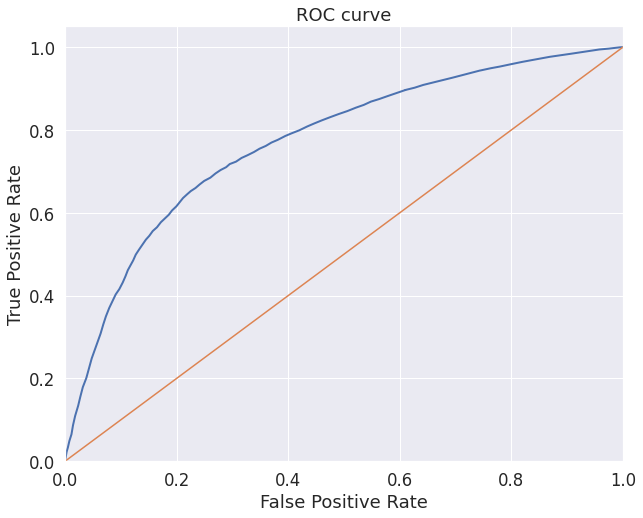

In [ ]:
roc_curve_plot(y_test, y_score_RF)

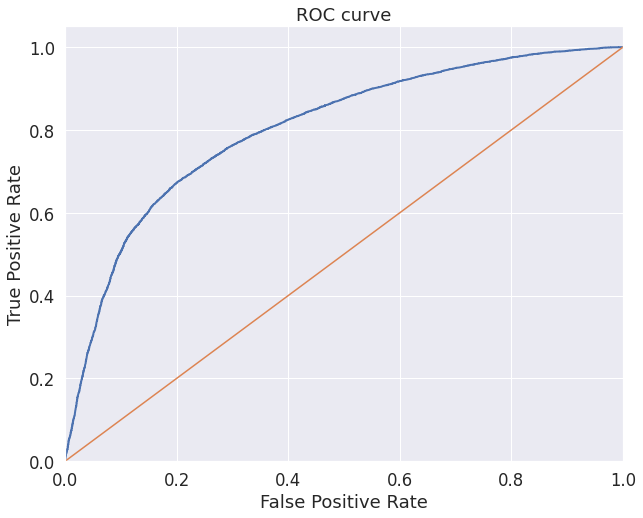

In [ ]:
roc_curve_plot(y_test, y_score_GB)

In [ ]:
from sklearn.metrics import roc_auc_score, log_loss

#Ваш код здесь
print("roc auc score: {}".format(roc_auc_score(y_true=y_test, y_score=classifier_LR.predict_proba(X_test)[:,1])))
print("log loss score: {}".format(log_loss(y_true=y_test, y_pred=classifier_LR.predict_proba(X_test)[:,1])))

roc auc score: 0.7840347790421852
log loss score: 0.5779604008230668


In [ ]:
print("roc auc score: {}".format(roc_auc_score(y_true=y_test, y_score=classifier_RF.predict_proba(X_test)[:,1])))
print("log loss score: {}".format(log_loss(y_true=y_test, y_pred=classifier_RF.predict_proba(X_test)[:,1])))

roc auc score: 0.7710366181802983
log loss score: 0.5992984853728378


In [ ]:
print("roc auc score: {}".format(roc_auc_score(y_true=y_test, y_score=classifier_GB.predict_proba(X_test)[:,1])))
print("log loss score: {}".format(log_loss(y_true=y_test, y_pred=classifier_GB.predict_proba(X_test)[:,1])))

roc auc score: 0.8026153641179974
log loss score: 0.5397460438742135


Посомтрим на матрицу ошибок

In [ ]:
import itertools
def my_plot_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[5858 2962]
 [1840 6840]]


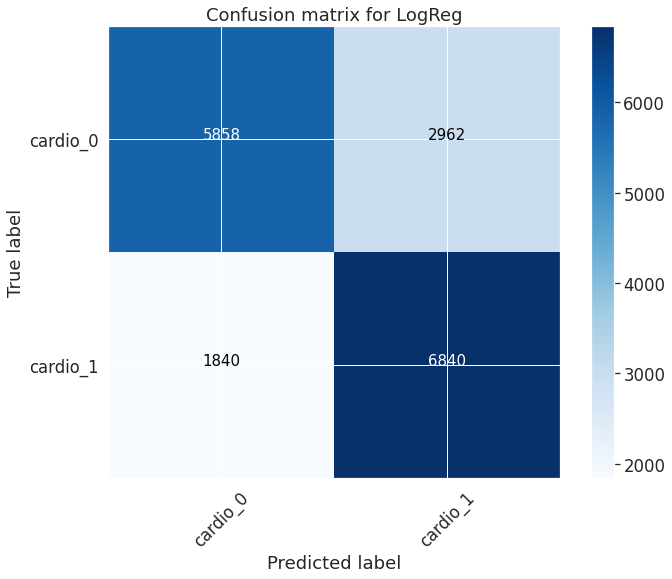

In [ ]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_LR = confusion_matrix(y_test, y_score_LR>thresholds_LR)
plt.figure(figsize=(10, 8))
my_plot_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'],title='Confusion matrix for LogReg')
plt.savefig("conf_matrix.png")
plt.show()

Confusion matrix, without normalization
[[5858 2962]
 [1840 6840]]


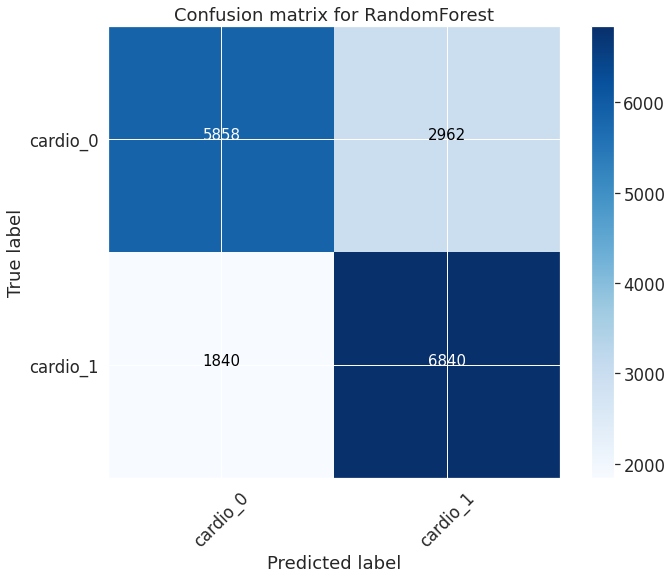

In [ ]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_RF = confusion_matrix(y_test, y_score_RF>thresholds_RF)
plt.figure(figsize=(10, 8))
my_plot_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'],title='Confusion matrix for RandomForest')
plt.savefig("conf_matrix.png")
plt.show()

Confusion matrix, without normalization
[[5858 2962]
 [1840 6840]]


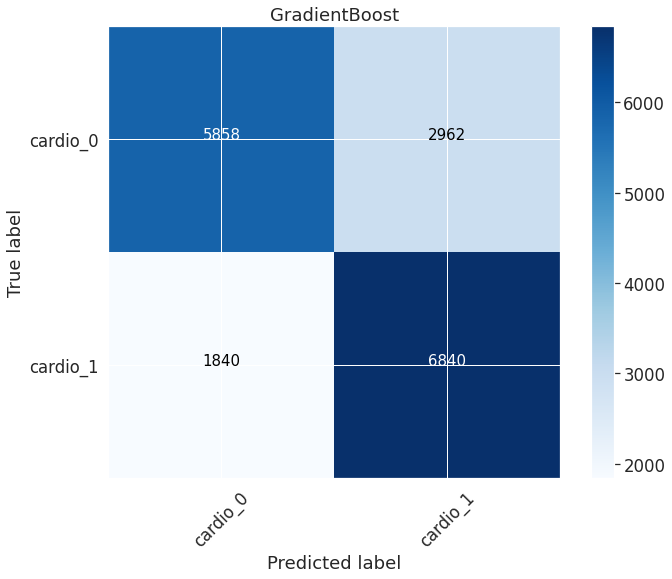

In [ ]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_GB = confusion_matrix(y_test, y_score_GB>thresholds_GB)
plt.figure(figsize=(10, 8))
my_plot_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'],title='Confusion Matrix for GradientBoost')
plt.savefig("conf_matrix.png")
plt.show()

Посчитаем FPR, TPR

In [ ]:
TN_LR = cnf_matrix_LR[0][0]
FN_LR = cnf_matrix_LR[1][0]
TP_LR = cnf_matrix_LR[1][1]
FP_LR = cnf_matrix_LR[0][1]

TPR_LR = TP_LR/(TP_LR+FN_LR)
FPR_LR = FP_LR/(FP_LR+TN_LR)
TNR_LR = TN_LR/(FP_LR+TN_LR)
TPR_LR, FPR_LR, TNR_LR

(0.837442396313364, 0.44886621315192743, 0.5511337868480726)

In [ ]:
TN_RF = cnf_matrix_RF[0][0]
FN_RF = cnf_matrix_RF[1][0]
TP_RF = cnf_matrix_RF[1][1]
FP_RF = cnf_matrix_RF[0][1]

TPR_RF = TP_RF/(TP_RF+FN_RF)
FPR_RF = FP_RF/(FP_RF+TN_RF)
TNR_RF = TN_RF/(FP_RF+TN_RF)
TPR_RF, FPR_RF, TNR_RF

(0.8084101382488479, 0.43412698412698414, 0.5658730158730159)

In [ ]:
TN_GB = cnf_matrix_GB[0][0]
FN_GB = cnf_matrix_GB[1][0]
TP_GB = cnf_matrix_GB[1][1]
FP_GB = cnf_matrix_GB[0][1]

TPR_GB = TP_GB/(TP_GB+FN_GB)
FPR_GB = FP_GB/(FP_GB+TN_GB)
TNR_GB = TN_GB/(FP_GB+TN_GB)
TPR_GB, FPR_GB, TNR_GB

(0.7880184331797235, 0.33582766439909295, 0.664172335600907)

Хорошая ли модель у нас получилась? - ответ сильно зависит от внешних факторов (какое количество FP мы можем допустить)

In [ ]:
print(f'Precision: LogReg:{pres_LR} RandomForest:{pres_RF} GradBoost:{pres_GB}')
print(f'Recall: LogReg:{recall_LR} RandomForest:{recall_RF} GradBoost:{recall_GB}')
print(f'F-score: LogReg:{fscore_LR} RandomForest:{fscore_RF} GradBoost:{fscore_GB}')


Precision: LogReg:0.6474307596402173 RandomForest:0.6426690876078075 GradBoost:0.6978475976741814
Recall: LogReg:0.8375576036866359 RandomForest:0.8155529953917051 GradBoost:0.7881336405529954
F-score: LogReg:0.7303229695112764 RandomForest:0.7188626554963188 GradBoost:0.7402477952713303


### Домашнее задание

1. обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта
2. при обучении моделей обязательно использовать кроссвалидацию
3. вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики)
4. сделать выводы о том, какая модель справилась с задачей лучше других
5. (опциональный вопрос) какая метрика (precision_recall_curve или roc_auc_curve) больше подходит в случае сильного дисбаланса классов? (когда объектов одного из классов намного больше чем другого). 

p.s.В вопросе проще разобраться, если вспомнить оси на графике roc auc curve и рассмотреть такой пример:

Имеется 100000 объектов, из которых только 100 - класс "1" (99900 - класс "0", соответственно). 
Допустим, у нас две модели:

- первая помечает 100 объектов как класс 1, но TP = 90
- вторая помечает 1000 объектов как класс 1, но TP такой же - 90

Какая модель лучше и почему? И что позволяет легче сделать вывод - roc_auc_curve или precision_recall_curve?

### Ссылки

1. https://dyakonov.org/2017/07/28/auc-roc-площадь-под-кривой-ошибок/
2. https://en.wikipedia.org/wiki/Receiver_operating_characteristic